In [1]:
import logging
import os

import gensim
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from rich import print
from tqdm import tqdm
from utils import get_input_files, view_sample_graph

%load_ext rich
%load_ext autoreload
%autoreload 2

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

nltk.download("stopwords")
pd.set_option("display.max_columns", None)
pyLDAvis.enable_notebook()
tqdm.pandas()

[nltk_data] Downloading package stopwords to C:\Users\Lakshya
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [2]:
SUBREDDIT_NAME = "FortNiteBR"

### Submissions

In [ ]:
submission_columns_ = [
    "author",
    "created_utc",
    "domain",
    "id",
    "is_self",
    "num_comments",
    "score",
    "selftext",
    "subreddit",
    "subreddit_id",
    "subreddit_subscribers",
    "title",
    "url",
    "downs",
    "ups",
]

submissions = get_input_files(SUBREDDIT_NAME, type="submissions").read()[
    submission_columns_
]

submissions = submissions[~submissions["author"].isin(["[deleted]", "[removed]"])]

### Comments

In [ ]:
comments_columns_ = [
    "body",
    "name",
    "link_id",
    "parent_id",
    "downs",
    "subreddit",
    "score",
    "ups",
    "author",
    "created_utc",
    "permalink",
]


comments = get_input_files(SUBREDDIT_NAME, type="comments").read()[comments_columns_]

comments = comments[~comments["author"].isin(["[deleted]", "[removed]"])]
comments["submission_id"] = comments["link_id"].str.split("t3_").str[1]

In [ ]:
comments

## Topic modeling

In [ ]:
submissions['year'] = pd.to_datetime(submissions['created_utc'], unit='s').dt.year

In [ ]:
# Clean submission title
stop_words = stopwords.words("english")
stop_words.extend(["google"])

def clean_post_title(post):
    return " ".join(
        [
            word
            for word in simple_preprocess(post)
            if word not in stop_words and len(word) > 2
        ]
    )

In [ ]:
sample = submissions["title"].sample(10, random_state=42).tolist()
print(sample)

sample_cleaned = [clean_post_title(post) for post in sample]
print(sample_cleaned)

In [ ]:
submissions["clean_title"] = submissions["title"].progress_apply(clean_post_title)

In [ ]:
submissions

In [ ]:
titles = submissions['clean_title'].apply(str.split)
id2word = corpora.Dictionary(titles)

In [ ]:
corpus = [id2word.doc2bow(title) for title in titles]

In [ ]:
# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    workers=3,
    passes=5,
    iterations=200,
    random_state=42
)

In [ ]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]


In [ ]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

In [ ]:
topic_words = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)

print(topic_words)

### Topic Summaries

#### Topic 0: Google products and services
  Keywords: "chrome", "android", "play", "youtube", "app"
  
  Summary: Focuses on Google's various products and services, highlighting mobile applications and platforms like Google Play Store.

#### Topic 1: Search and cloud storage
  Keywords: "search", "drive", "photos", "results", "files"
  
  Summary: Centers on Google's search capabilities and cloud storage solutions, specifically Google Drive and Google Photos.

#### Topic 2: Tech company news and reviews
  Keywords: "apple", "news", "facebook", "reviews", "data", "says"
  
  Summary: Captures discussions and news about major tech companies, comparing products and data practices among giants like Apple and Facebook.

#### Topic 3: Account support and troubleshooting
  Keywords: "account", "help", "gmail", "phone", "email", "need", "please"
  
  Summary: Relates to user support for Google accounts and services, with a strong emphasis on Gmail troubleshooting.

#### Topic 4: Hardware products
  Keywords: "pixel", "apple", "watch", "iphone", "pro"
  
  Summary: Discusses hardware products, comparing features, pricing, and reviews of items like Pixel phones, Apple Watch, and iPhones.

In [ ]:
topic_names = {
    0: "Google products and services",
    1: "Search and cloud storage",
    2: "Tech company news and reviews",
    3: "Account support and troubleshooting",
    4: "Hardware products",
}

In [ ]:
# Assign submission to topic
def assign_topic(lda_model, corpus, topic_interpretation):
    """
    Assigns a topic to each submission based on the topic with the highest probability

    :param lda_model: LDA model
    :param corpus: corpus
    :param topic_interpretation: dictionary with topic interpretation (e.g. {0: 'topic1', 1: 'topic2'})
    """
    doc_lda = lda_model[corpus]
    topics = [max(doc, key=lambda x: x[1])[0] for doc in doc_lda]
    return [topic_interpretation[topic] for topic in topics]


submissions["topic"] = assign_topic(lda_model, corpus, topic_names)

submissions

In [ ]:
submissions.to_csv(f"data/{SUBREDDIT_NAME}_submissions.csv", index=False)
comments.to_csv(f"data/{SUBREDDIT_NAME}_comments.csv", index=False)

In [ ]:
submissions = pd.read_csv(f"data/{SUBREDDIT_NAME}_submissions.csv")
comments = pd.read_csv(f"data/{SUBREDDIT_NAME}_comments.csv")

In [ ]:
SELECTED_TOPIC = topic_names[0]

submission_t = submissions[submissions["topic"] == SELECTED_TOPIC]
comments_t = comments[comments["submission_id"].isin(submission_t["id"])]

In [ ]:
comments_t

In [ ]:
user_weights = (
    comments_t.groupby("author")
    .agg({"score": "mean", "body": "count"})
    .rename(columns={"score": "average_score", "body": "num_comments"})
    .sort_values(by=["num_comments", "average_score"], ascending=False)
)

user_weights


In [ ]:
# Top users by number of comments
comments_t.groupby("author")["submission_id"].count().sort_values(ascending=False).head(
    10
)

## Network analysis

### Create bipartite graph

In [ ]:
def create_bipartite_graph(df: pd.DataFrame):
    B = nx.Graph()

    users = df["author"].unique()
    posts = df["link_id"].unique()

    B.add_nodes_from(users, bipartite=0)
    B.add_nodes_from(posts, bipartite=1)

    edges = [
        (row["author"], row["link_id"], row["score"]) for index, row in df.iterrows()
    ]

    B.add_weighted_edges_from(edges)

    if nx.is_bipartite(B):
        user_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
        post_nodes = set(B) - user_nodes

    return user_nodes, post_nodes, B


def project_bipartite_graph(B, nodes):
    return nx.bipartite.weighted_projected_graph(B, nodes)


In [ ]:
user_nodes_t, post_nodes_t, B_t = create_bipartite_graph(comments_t)

G_user_t = project_bipartite_graph(B_t, user_nodes_t)

In [ ]:
list(G_user_t.edges(data=True))[45:50]

In [ ]:
len(G_user_t.nodes), len(G_user_t.edges)

### Add node attributes

In [ ]:
user_weights

In [ ]:
for attribute in user_weights.columns:
    nx.set_node_attributes(
        G_user_t,
        pd.Series(user_weights[attribute], index=user_weights.index).to_dict(),
        attribute,
    )

In [ ]:
largest_cc_t = max(nx.connected_components(G_user_t), key=len)
G_largest_cc_t = G_user_t.subgraph(largest_cc_t)

In [ ]:
len(G_largest_cc_t.nodes), len(G_largest_cc_t.edges)

In [ ]:
view_sample_graph(G_largest_cc_t, 100)

In [ ]:
# nx.write_gexf(G_largest_cc_t, f"./data/{SUBREDDIT_NAME}_{topic_names[0]}_graph.gexf")

In [ ]:
G_largest_cc_t = nx.read_gexf(f"./data/{SUBREDDIT_NAME}_{topic_names[0]}_graph.gexf")

In [ ]:
# Filter nodes based on the number of comments
nodes_with_more_than_one_comment = [
    node
    for node, attr in G_largest_cc_t.nodes(data=True)
    if attr.get("num_comments", 0) > 1
]

G_filtered = G_largest_cc_t.subgraph(nodes_with_more_than_one_comment)

len(G_filtered.nodes), len(G_filtered.edges)

### Centrality scores

In [ ]:
degree_centrality = pd.DataFrame(
    nx.degree_centrality(G_filtered).items(),
    columns=["author", "degree_centrality"],
).sort_values(by="degree_centrality", ascending=False)


In [ ]:
betweenness_centrality = pd.DataFrame(
    nx.betweenness_centrality(G_filtered, k=50).items(),
    columns=["author", "betweenness_centrality"],
).sort_values(by="betweenness_centrality", ascending=False)


In [ ]:
eigen_centrality = pd.DataFrame(
    nx.eigenvector_centrality(G_filtered, max_iter=100, weight="weight").items(),
    columns=["author", "eigen_centrality"],
).sort_values(by="eigen_centrality", ascending=False)

In [ ]:
centrality_scores = pd.concat(
    [
        degree_centrality.set_index("author"),
        betweenness_centrality.set_index("author"),
        eigen_centrality.set_index("author"),
    ],
    axis=1,
)

centrality_scores


In [ ]:
filtered_node_data = pd.DataFrame(
    G_filtered.nodes(data=True), columns=["author", "attrs"]
)

filtered_node_data

In [ ]:
filtered_node_data = (
    pd.concat(
        [
            filtered_node_data["author"],
            pd.json_normalize(filtered_node_data["attrs"]),
        ],
        axis=1,
    )
    .set_index("author")
    .merge(centrality_scores, left_index=True, right_index=True)
)

filtered_node_data

In [ ]:
filtered_node_data["influencer_score"] = (
    filtered_node_data["degree_centrality"]
    + filtered_node_data["betweenness_centrality"]
    + filtered_node_data["eigen_centrality"]
) * filtered_node_data["num_comments"]

filtered_node_data.sort_values(by="influencer_score", ascending=False)

In [ ]:
# Add centrality scores and influencer score as node attributes
attributes = filtered_node_data[
    [
        "degree_centrality",
        "betweenness_centrality",
        "eigen_centrality",
        "influencer_score",
    ]
].to_dict("index")
nx.set_node_attributes(G_filtered, attributes)


### Community detection

In [ ]:
communities = nx.community.louvain_communities(G_filtered, weight="weight", seed=42)

In [ ]:
# Add community as node attribute to the graph
for community_idx, community in enumerate(communities):
    for node in community:
        G_filtered.nodes[node]["community"] = community_idx

<Figure size 2000x2000 with 0 Axes>

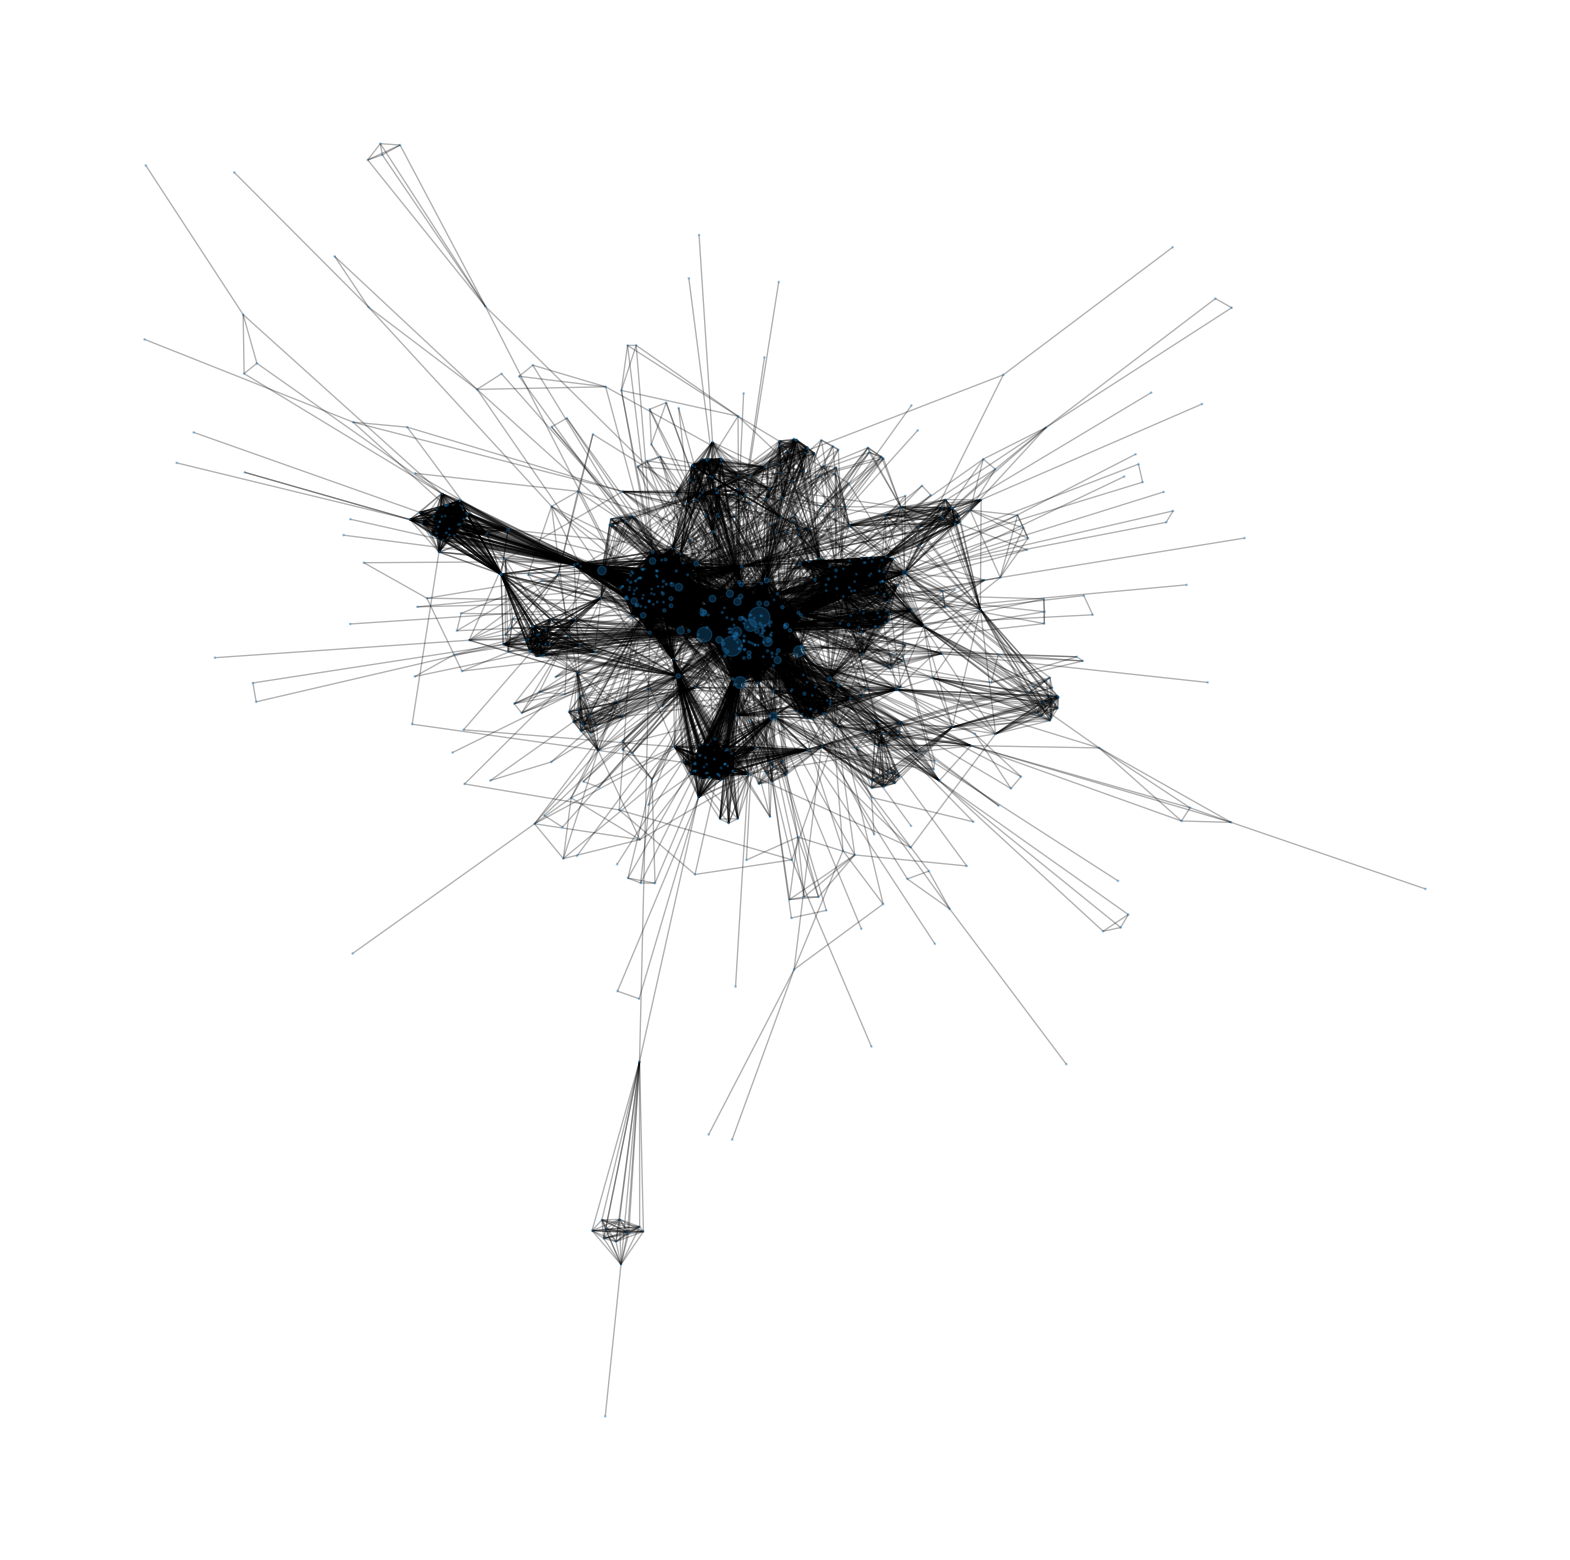

In [95]:
G_filtered_community = G_filtered.subgraph(communities[0])

plt.figure(figsize=(20, 20))

pos = nx.spring_layout(G_filtered_community, seed=42)

node_size = [
    (d.get("influencer_score", 0) * 10 + 1)
    for n, d in G_filtered_community.nodes(data=True)
]

node_color = [d.get("community", 0) for n, d in G_filtered_community.nodes(data=True)]

fig, ax = plt.subplots(figsize=(20, 20))
ax.set_axis_off()

nx.draw_networkx_nodes(
    G_filtered_community,
    pos,
    node_size=node_size,
    node_color=node_color,
    cmap=plt.cm.tab20,
    alpha=0.3,
    ax=ax,
)

nx.draw_networkx_edges(G_filtered_community, pos, alpha=0.3, ax=ax)
# nx.draw_networkx_labels(G_filtered_community, pos, font_size=12, ax=ax)
